In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import glob
from datetime import datetime
import xml.etree.ElementTree as ET 
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
path_an = "/content/drive/MyDrive/project_data/annotations"
annot_dic = {
    "file":[],
    "name":[],    
    "width":[],
    "height":[],
    "xmin":[],
    "ymin":[],   
    "xmax":[],
    "ymax":[],
}

In [ ]:
for anno in glob.glob(path_an+"/*.xml"):
  tree = ET.parse(anno)
  width = 0
  height = 0
  for elem in tree.iter():
    if 'size' in elem.tag:
      for attr in list(elem):
        if 'width' in attr.tag: 
            width = int(round(float(attr.text)))
        if 'height' in attr.tag:
            height = int(round(float(attr.text)))    

    if 'object' in elem.tag:
      for attr in list(elem):          
        if 'name' in attr.tag:
          name = attr.text                 
          annot_dic['name']+=[name]
          annot_dic['width']+=[width]
          annot_dic['height']+=[height] 
          annot_dic['file']+=[anno.split('/')[-1][0:-4]] 
                        
        if 'bndbox' in attr.tag:
          for dim in list(attr):
            if 'xmin' in dim.tag:
                xmin = int(round(float(dim.text)))
                annot_dic['xmin']+=[xmin]
            if 'ymin' in dim.tag:
                ymin = int(round(float(dim.text)))
                annot_dic['ymin']+=[ymin]                                
            if 'xmax' in dim.tag:
                xmax = int(round(float(dim.text)))
                annot_dic['xmax']+=[xmax]                                
            if 'ymax' in dim.tag:
                ymax = int(round(float(dim.text)))
                annot_dic['ymax']+=[ymax]

In [ ]:
df_anno = pd.DataFrame(annot_dic)

In [ ]:
df_anno['name'].value_counts()

with_mask                3232
without_mask              717
mask_weared_incorrect     123
Name: name, dtype: int64

In [ ]:
df_anno['label_1'] = df_anno['name'].apply(lambda x: 0 if x=='with_mask' else 1)
df_anno['label_2'] = df_anno['name'].apply(lambda x: 0 if x=='with_mask' else (1 if x=='without_mask' else 2))

In [ ]:
df_anno.head(-5)

,file,name,width,height,xmin,ymin,xmax,ymax,label_1,label_2
0,maksssksksss109,with_mask,400,400,216,92,372,251,0,0
1,maksssksksss105,with_mask,400,267,178,143,213,202,0,0
2,maksssksksss105,with_mask,400,267,280,103,312,145,0,0
3,maksssksksss105,with_mask,400,267,320,79,352,119,0,0
4,maksssksksss105,with_mask,400,267,365,53,390,84,0,0
...,...,...,...,...,...,...,...,...,...,...
4062,maksssksksss156,with_mask,400,267,278,73,291,87,0,0
4063,maksssksksss156,mask_weared_incorrect,400,267,366,70,385,91,1,2
4064,maksssksksss156,mask_weared_incorrect,400,267,181,40,203,67,1,2
4065,maksssksksss156,mask_weared_incorrect,400,267,36,63,59,88,1,2


In [ ]:
from PIL import Image 
BASE_DIR_IMG = '/content/drive/MyDrive/project_data/images/'
def crop_image(file, xmin, ymin, xmax, ymax, is_im_arr=False):
  if is_im_arr is False:
    im = Image.open(BASE_DIR_IMG + file + '.png')
    im_arr = np.array(im)
  else:
    im_arr = np.array(file)
  # cropping
  im_cropped = im_arr[ymin:ymax, xmin:xmax, :3]
  return im_cropped

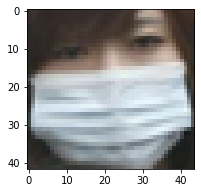

In [ ]:
row = df_anno.iloc[100]
im_cropped = crop_image(row.file, row.xmin, row.ymin, row.xmax, row.ymax)
# plot image cropped
plt.figure(figsize=(3,3))
plt.imshow(im_cropped)
plt.show()

In [ ]:
# create data batch
import tensorflow as tf

def create_data_batch(X, y=None, batch_size=32, valid_data=False, test_data=False):
  """
      We create dataset and iter to transform file_path to cropped image
  """
  if test_data:
    print('Creating test dataset')
    ## Edited:
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    data_batch = data.batch(batch_size)
  elif valid_data:
    print('Creating valid dataset')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    data_batch = data.batch(batch_size)
  else:
    print('Creating Training dataset')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    data = data.shuffle(buffer_size=len(X))
    data_batch = data.batch(batch_size)
  return data_batch

In [ ]:
images = []
labels = []
for i in range(len(df_anno)):
  row = df_anno.iloc[i]
  im_cropped = crop_image(row.file, row.xmin, row.ymin, row.xmax, row.ymax)
  im_resized = cv2.resize(im_cropped, (128, 128))
  im_resized = im_resized / 255.0
  images.append(im_resized)
  labels.append(row.label_2)
len(images), len(labels)

(4072, 4072)

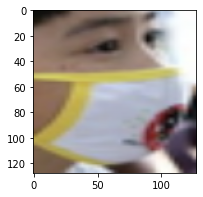

In [ ]:
plt.figure(figsize=(3,3))
plt.imshow(images[1])
plt.show()

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)


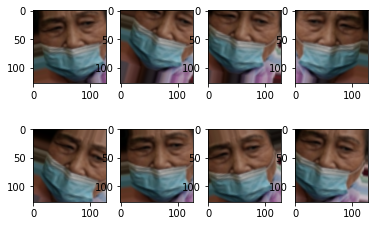

In [ ]:
# Try Data Augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20, horizontal_flip=0.5, width_shift_range=0.15, height_shift_range=0.15)
aug_img = images[22].reshape(1, 128, 128, 3)
datagen.fit(aug_img)
i=0
batch_size=8
for img_batch in datagen.flow(aug_img, batch_size=8):
    for img in img_batch:
        plt.subplot(240+ 1 + i)
        plt.imshow(img)
        i=i+1
        print(img.shape)    
    if i >= batch_size:
        break

In [ ]:
incorr_idx = []
for i in range(0, len(labels)):
  if (labels[i]==2):
    incorr_idx.append(i)
len(incorr_idx)

123

In [ ]:
# Data Augmentation
#aug_images=[]
#aug_labels=[]
for i in range(0, len(incorr_idx)):
  incorr_img = images[incorr_idx[i]].reshape(1, 128, 128, 3)
  datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20, horizontal_flip=0.5, width_shift_range=0.15, height_shift_range=0.15)
  datagen.fit(incorr_img)
  j=0
  batch_size=4
  for img_batch in datagen.flow(incorr_img, batch_size=4):
    for auged_img in img_batch:
      images.append(auged_img)
      labels.append(2)
      j=j+1   
    if j >= batch_size:
      break
  
print(len(images))
print(len(labels))

4564
4564


In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
labels_encoder = le.fit_transform(labels)
targets = np.array(labels)
targets.shape

(4564,)

In [ ]:
unique, counts = np.unique(targets, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0 3232]
 [   1  717]
 [   2  615]]


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_notrain, y_train, y_notrain = train_test_split(images, targets, test_size=0.3, random_state=42)
print(len(X_train))
print(len(y_notrain))

3194
1370


In [ ]:
X_val, X_test, y_val, y_test = train_test_split(X_notrain, y_notrain, test_size=0.66, random_state=42)
print(len(X_val))
print(len(y_test))

465
905


In [ ]:
train_data = create_data_batch(X_train, y=y_train)
train_data.element_spec

Creating Training dataset


(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float64, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [ ]:
val_data = create_data_batch(X_val, y=y_val, valid_data=True)
val_data.element_spec

Creating valid dataset


(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float64, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [ ]:
test_data = create_data_batch(X_test, test_data=True)

Creating test dataset


In [ ]:
# VGG19 Model:
# Transfer Study:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras import Sequential
from keras.layers import Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

for layer in vgg19.layers:
    layer.trainable = False

model = Sequential()
model.add(vgg19)
model.add(Flatten())
model.add(Dense(3,activation='softmax'))
model.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 3)                 24579     
                                                                 
Total params: 20,048,963
Trainable params: 24,579
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy", metrics ="accuracy")
# create callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)
history = model.fit(train_data, validation_data=val_data, epochs=20, callbacks=[early_stopping])

Epoch 1/20
100/100 [==============================] - 11s 25ms/step - loss: 0.6294 - accuracy: 0.7486 - val_loss: 0.4751 - val_accuracy: 0.8215
Epoch 2/20
100/100 [==============================] - 2s 16ms/step - loss: 0.4254 - accuracy: 0.8303 - val_loss: 0.4252 - val_accuracy: 0.8129
Epoch 3/20
100/100 [==============================] - 2s 16ms/step - loss: 0.3619 - accuracy: 0.8557 - val_loss: 0.3932 - val_accuracy: 0.8280
Epoch 4/20
100/100 [==============================] - 2s 17ms/step - loss: 0.3073 - accuracy: 0.8873 - val_loss: 0.4256 - val_accuracy: 0.8280
Epoch 5/20
100/100 [==============================] - 2s 17ms/step - loss: 0.3087 - accuracy: 0.8804 - val_loss: 0.3600 - val_accuracy: 0.8731
Epoch 6/20
100/100 [==============================] - 2s 16ms/step - loss: 0.2672 - accuracy: 0.9008 - val_loss: 0.3723 - val_accuracy: 0.8581
Epoch 7/20
100/100 [==============================] - 2s 16ms/step - loss: 0.2638 - accuracy: 0.8986 - val_loss: 0.3726 - val_accuracy: 0.851

In [ ]:
from tensorflow import keras
for layer in vgg19.layers:
    layer.trainable = True

model.compile(optimizer=keras.optimizers.Adam(1e-5),loss="sparse_categorical_crossentropy", metrics ="accuracy")
# create callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)
history = model.fit(train_data, validation_data=val_data, epochs=10, callbacks=[early_stopping])

Epoch 1/10
100/100 [==============================] - 7s 42ms/step - loss: 0.1548 - accuracy: 0.9452 - val_loss: 0.2644 - val_accuracy: 0.9118
Epoch 2/10
100/100 [==============================] - 4s 36ms/step - loss: 0.0769 - accuracy: 0.9753 - val_loss: 0.2773 - val_accuracy: 0.9097
Epoch 3/10
100/100 [==============================] - 4s 36ms/step - loss: 0.0528 - accuracy: 0.9822 - val_loss: 0.2571 - val_accuracy: 0.9333
Epoch 4/10
100/100 [==============================] - 4s 36ms/step - loss: 0.0519 - accuracy: 0.9828 - val_loss: 0.2050 - val_accuracy: 0.9312
Epoch 5/10
100/100 [==============================] - 4s 36ms/step - loss: 0.0363 - accuracy: 0.9881 - val_loss: 0.2366 - val_accuracy: 0.9376
Epoch 6/10
100/100 [==============================] - 4s 36ms/step - loss: 0.0167 - accuracy: 0.9941 - val_loss: 0.2354 - val_accuracy: 0.9355
Epoch 7/10
100/100 [==============================] - 4s 36ms/step - loss: 0.0089 - accuracy: 0.9978 - val_loss: 0.2140 - val_accuracy: 0.9398

In [ ]:
pred = model.predict(test_data)
pred = np.argmax(pred, axis=1)

29/29 [==============================] - 1s 22ms/step


In [ ]:
count=0
for i in range(len(y_test)):
  if (pred[i]==y_test[i]):
    count=count+1
count/len(y_test)

0.9138121546961326

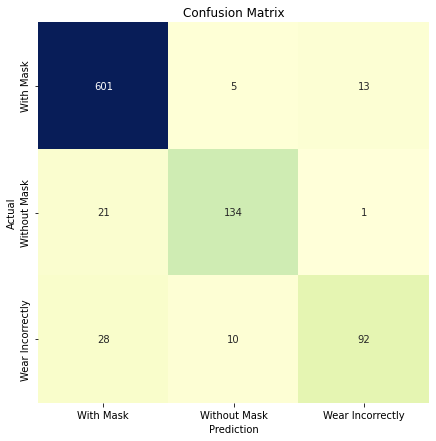

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, pred, labels=[0,1,2])
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='YlGnBu', cbar=False)
plt.xticks(ticks=[0.5, 1.5, 2.5], labels=['With Mask','Without Mask','Wear Incorrectly'])
plt.yticks(ticks=[0.5, 1.5, 2.5], labels=['With Mask','Without Mask','Wear Incorrectly'])
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
clr = classification_report(y_test, pred, labels=[0,1,2], target_names=['With Mask','Without Mask','Wear Incorrectly'])
print(clr)

                  precision    recall  f1-score   support

       With Mask       0.92      0.97      0.95       619
    Without Mask       0.90      0.86      0.88       156
Wear Incorrectly       0.87      0.71      0.78       130

        accuracy                           0.91       905
       macro avg       0.90      0.85      0.87       905
    weighted avg       0.91      0.91      0.91       905



## Binary Classification

In [ ]:
# Binary Classification:
df_anno = df_anno[df_anno.label_2!=2][:]
images = []
labels_bin = []
for i in range(len(df_anno)):
  row = df_anno.iloc[i]
  im_cropped = crop_image(row.file, row.xmin, row.ymin, row.xmax, row.ymax)
  im_resized = cv2.resize(im_cropped, (128, 128))
  im_resized = im_resized / 255.0
  images.append(im_resized)
  labels_bin.append(row.label_2)
len(images), len(labels_bin)

(3949, 3949)

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
labels_encoder = le.fit_transform(labels_bin)
targets = np.array(labels_bin)
print(targets.shape)
unique, counts = np.unique(targets, return_counts=True)
print(np.asarray((unique, counts)).T)

(3949,)
[[   0 3232]
 [   1  717]]


In [ ]:
print(4072-3949)
print(3232/3949)

123
0.8184350468473031


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_notrain, y_train, y_notrain = train_test_split(images, targets, test_size=0.3, random_state=42)
print(len(X_train))
print(len(y_notrain))
X_val, X_test, y_val, y_test = train_test_split(X_notrain, y_notrain, test_size=0.66, random_state=42)
print(len(X_val))
print(len(y_test))

2764
1185
402
783


In [ ]:
2764+402+783

3949

In [ ]:
train_data = create_data_batch(X_train, y=y_train)
train_data.element_spec

Creating Training dataset


(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float64, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [ ]:
val_data = create_data_batch(X_val, y=y_val, valid_data=True)
val_data.element_spec

Creating valid dataset


(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float64, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [ ]:
test_data = create_data_batch(X_test, test_data=True)

Creating test dataset


In [ ]:
# Binary Classification:
# Transfer Study:
vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

for layer in vgg19.layers:
    layer.trainable = False
    
model_bin = Sequential()
model_bin.add(vgg19)
model_bin.add(Flatten())
model_bin.add(Dense(1,activation='sigmoid'))
model_bin.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 8193      
                                                                 
Total params: 20,032,577
Trainable params: 8,193
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
model_bin.compile(optimizer="adam",loss="binary_crossentropy", metrics ="accuracy")
# create callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)
history_bin = model_bin.fit(train_data, validation_data=val_data, epochs=20, callbacks=[early_stopping])

Epoch 1/20
87/87 [==============================] - 10s 97ms/step - loss: 0.3849 - accuracy: 0.8213 - val_loss: 0.2767 - val_accuracy: 0.8856
Epoch 2/20
87/87 [==============================] - 6s 72ms/step - loss: 0.2638 - accuracy: 0.8788 - val_loss: 0.2366 - val_accuracy: 0.9154
Epoch 3/20
87/87 [==============================] - 6s 72ms/step - loss: 0.2265 - accuracy: 0.9038 - val_loss: 0.2265 - val_accuracy: 0.8881
Epoch 4/20
87/87 [==============================] - 6s 72ms/step - loss: 0.2004 - accuracy: 0.9139 - val_loss: 0.1975 - val_accuracy: 0.9254
Epoch 5/20
87/87 [==============================] - 6s 73ms/step - loss: 0.1856 - accuracy: 0.9211 - val_loss: 0.1898 - val_accuracy: 0.9279
Epoch 6/20
87/87 [==============================] - 6s 73ms/step - loss: 0.1723 - accuracy: 0.9313 - val_loss: 0.1876 - val_accuracy: 0.9279
Epoch 7/20
87/87 [==============================] - 6s 73ms/step - loss: 0.1607 - accuracy: 0.9378 - val_loss: 0.2022 - val_accuracy: 0.9154
Epoch 8/20
8

In [ ]:
from tensorflow import keras
for layer in vgg19.layers:
    layer.trainable = True

model_bin.compile(optimizer=keras.optimizers.Adam(1e-5),loss="binary_crossentropy", metrics ="accuracy")
# create callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)
history_bin = model_bin.fit(train_data, validation_data=val_data, epochs=10, callbacks=[early_stopping])

Epoch 1/10
87/87 [==============================] - 19s 206ms/step - loss: 0.1076 - accuracy: 0.9595 - val_loss: 0.0882 - val_accuracy: 0.9726
Epoch 2/10
87/87 [==============================] - 16s 186ms/step - loss: 0.0304 - accuracy: 0.9899 - val_loss: 0.0668 - val_accuracy: 0.9677
Epoch 3/10
87/87 [==============================] - 16s 186ms/step - loss: 0.0288 - accuracy: 0.9899 - val_loss: 0.1082 - val_accuracy: 0.9726
Epoch 4/10
87/87 [==============================] - 16s 188ms/step - loss: 0.0152 - accuracy: 0.9946 - val_loss: 0.0920 - val_accuracy: 0.9801
Epoch 5/10
87/87 [==============================] - 16s 189ms/step - loss: 0.0089 - accuracy: 0.9982 - val_loss: 0.0730 - val_accuracy: 0.9751
Epoch 6/10
87/87 [==============================] - 16s 189ms/step - loss: 0.0073 - accuracy: 0.9975 - val_loss: 0.1287 - val_accuracy: 0.9701
Epoch 7/10
87/87 [==============================] - 16s 188ms/step - loss: 0.0063 - accuracy: 0.9982 - val_loss: 0.1016 - val_accuracy: 0.9701

In [ ]:
pred_bin = model_bin.predict(test_data)
pred_bin = pred_bin.round()
pred_bin = pred_bin.flatten().astype('int32')
pred_bin

25/25 [==============================] - 3s 101ms/step


array([0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

783
0.9821200510855683


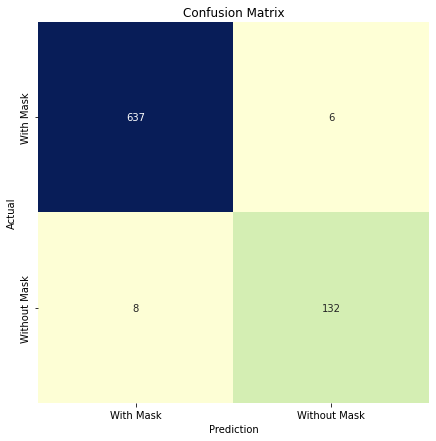

In [ ]:
count=0
for i in range(len(y_test)):
  if (pred_bin[i]==y_test[i]):
    count=count+1
print(len(y_test))
print(count/len(y_test))

cm_bin = confusion_matrix(y_test, pred_bin, labels=[0,1])
plt.figure(figsize=(7,7))
sns.heatmap(cm_bin, annot=True, fmt='g', vmin=0, cmap='YlGnBu', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=['With Mask','Without Mask'])
plt.yticks(ticks=[0.5, 1.5], labels=['With Mask','Without Mask'])
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
clr_bin = classification_report(y_test, pred_bin, labels=[0,1], target_names=['With Mask','Without Mask'])
print(clr_bin)

              precision    recall  f1-score   support

   With Mask       0.99      0.99      0.99       643
Without Mask       0.96      0.94      0.95       140

    accuracy                           0.98       783
   macro avg       0.97      0.97      0.97       783
weighted avg       0.98      0.98      0.98       783



## Binary, 10 epochs, trainable=True:

In [ ]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras import Sequential
from keras.layers import Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

for layer in vgg19.layers:
    layer.trainable = True 
    
model_bin = Sequential()
model_bin.add(vgg19)
model_bin.add(Flatten())
model_bin.add(Dense(1,activation='sigmoid'))
model_bin.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 8193      
                                                                 
Total params: 20,032,577
Trainable params: 20,032,577
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow import keras
model_bin.compile(optimizer=keras.optimizers.Adam(1e-5),loss="binary_crossentropy", metrics ="accuracy")
# create callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5) 
history_bin = model_bin.fit(train_data, validation_data=val_data, epochs=10, callbacks=[early_stopping])

Epoch 1/10
87/87 [==============================] - 5s 50ms/step - loss: 0.3069 - accuracy: 0.8517 - val_loss: 0.0787 - val_accuracy: 0.9701
Epoch 2/10
87/87 [==============================] - 3s 37ms/step - loss: 0.0667 - accuracy: 0.9768 - val_loss: 0.0899 - val_accuracy: 0.9677
Epoch 3/10
87/87 [==============================] - 3s 37ms/step - loss: 0.0388 - accuracy: 0.9873 - val_loss: 0.0558 - val_accuracy: 0.9801
Epoch 4/10
87/87 [==============================] - 3s 37ms/step - loss: 0.0276 - accuracy: 0.9931 - val_loss: 0.0581 - val_accuracy: 0.9801
Epoch 5/10
87/87 [==============================] - 3s 37ms/step - loss: 0.0188 - accuracy: 0.9935 - val_loss: 0.0675 - val_accuracy: 0.9751
Epoch 6/10
87/87 [==============================] - 3s 37ms/step - loss: 0.0151 - accuracy: 0.9949 - val_loss: 0.0580 - val_accuracy: 0.9701
Epoch 7/10
87/87 [==============================] - 3s 37ms/step - loss: 0.0116 - accuracy: 0.9964 - val_loss: 0.0612 - val_accuracy: 0.9776
Epoch 8/10
87

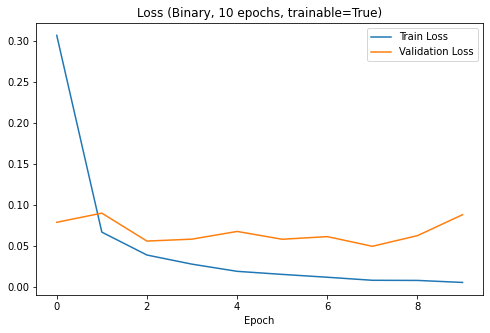

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history_bin.history['loss'], label='Train Loss')
plt.plot(history_bin.history['val_loss'], label='Validation Loss')
plt.title('Loss (Binary, 10 epochs, trainable=True)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

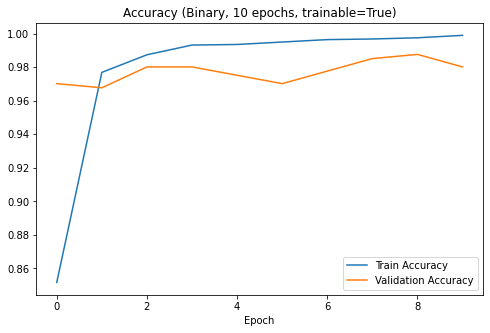

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history_bin.history['accuracy'], label='Train Accuracy')
plt.plot(history_bin.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy (Binary, 10 epochs, trainable=True)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
pred_bin = model_bin.predict(test_data)
pred_bin = pred_bin.round()
pred_bin = pred_bin.flatten().astype('int32')

25/25 [==============================] - 0s 14ms/step


783
0.9770114942528736


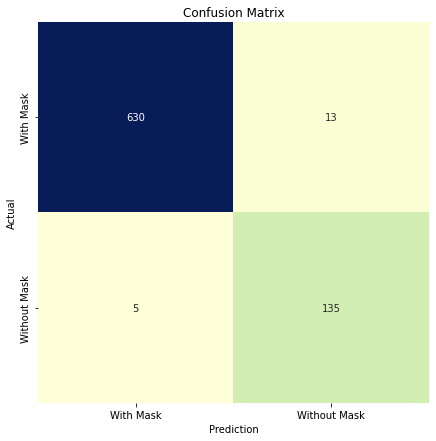

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
count=0
for i in range(len(y_test)):
  if (pred_bin[i]==y_test[i]):
    count=count+1
print(len(y_test))
print(count/len(y_test))

cm_bin = confusion_matrix(y_test, pred_bin, labels=[0,1])
plt.figure(figsize=(7,7))
sns.heatmap(cm_bin, annot=True, fmt='g', vmin=0, cmap='YlGnBu', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=['With Mask','Without Mask'])
plt.yticks(ticks=[0.5, 1.5], labels=['With Mask','Without Mask'])
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
clr_bin = classification_report(y_test, pred_bin, labels=[0,1], target_names=['With Mask','Without Mask'], digits=4)
print(clr_bin)

              precision    recall  f1-score   support

   With Mask     0.9921    0.9798    0.9859       643
Without Mask     0.9122    0.9643    0.9375       140

    accuracy                         0.9770       783
   macro avg     0.9521    0.9720    0.9617       783
weighted avg     0.9778    0.9770    0.9773       783



In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score
print(accuracy_score(y_test, pred_bin))
print(balanced_accuracy_score(y_test, pred_bin))

0.9770114942528736
0.9720339924461231


In [ ]:
!git clone https://github.com/gkeechin/vizgradcam

Cloning into 'vizgradcam'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 67 (delta 32), reused 24 (delta 6), pack-reused 0
Unpacking objects: 100% (67/67), done.


In [ ]:
cd /content/vizgradcam

/content/vizgradcam


1/1 [==============================] - 0s 188ms/step


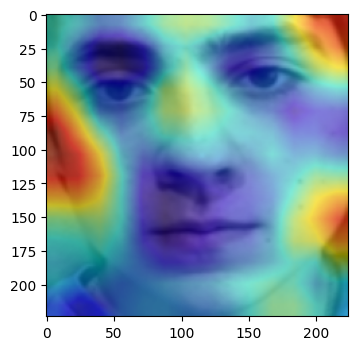

In [ ]:
# Grad-Cam (vgg19 imagenet weights)
from gradcam import VizGradCAM

test_img = X_test[3]
test_img = cv2.resize(test_img, (224,224))

VizGradCAM(
    VGG19(weights="imagenet"),  #load model
    test_img
)

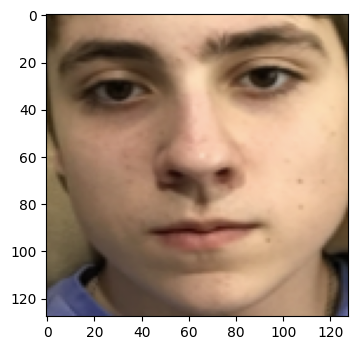

In [ ]:
plt.imshow(X_test[3])
plt.show()

## Custom Test (Multi-Class)

In [ ]:
test_img=np.reshape(test_img,[1,128,128,3])
res=model.predict(test_img)
res

1/1 [==============================] - 0s 21ms/step


array([[1.2257381e-01, 8.7738633e-01, 3.9815390e-05]], dtype=float32)

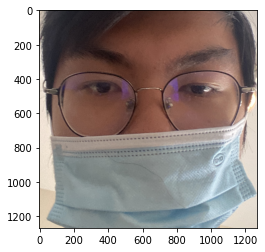

In [ ]:
from PIL import Image
cust_img = Image.open("/content/drive/MyDrive/project_data/zzl_mask.jpg")
plt.imshow(cust_img)
plt.show()

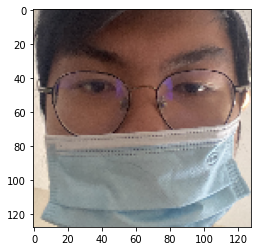

In [ ]:
cust_img = np.array(cust_img)
cust_img = cv2.resize(cust_img,(128,128))
cust_img = cust_img/255.0
plt.imshow(cust_img)
plt.show()
cust_img = np.reshape(cust_img,[1,128,128,3])

In [ ]:
res=model.predict(cust_img)
res

1/1 [==============================] - 0s 22ms/step


array([[9.9997532e-01, 4.1352503e-12, 2.4658530e-05]], dtype=float32)

In [ ]:
from PIL import Image
cust_img = Image.open("/content/drive/MyDrive/project_data/zzl_nomask.jpg")
plt.imshow(cust_img)
plt.show()

In [ ]:
cust_img = np.array(cust_img)
cust_img = cv2.resize(cust_img,(128,128))
cust_img = cust_img/255.0
plt.imshow(cust_img)
plt.show()
cust_img = np.reshape(cust_img,[1,128,128,3])

In [ ]:
res=model.predict(cust_img)
res

1/1 [==============================] - 0s 25ms/step


array([[8.278829e-02, 9.165590e-01, 6.526824e-04]], dtype=float32)

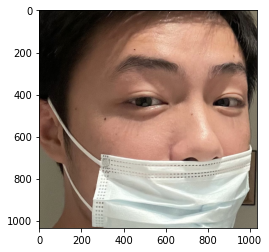

In [ ]:
from PIL import Image
cust_img = Image.open("/content/drive/MyDrive/project_data/skf_notcorr.jpg")
plt.imshow(cust_img)
plt.show()

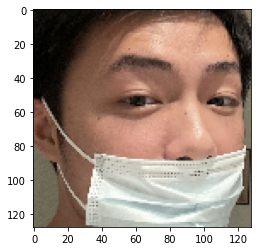

In [ ]:
cust_img = np.array(cust_img)
cust_img = cv2.resize(cust_img,(128,128))
cust_img = cust_img/255.0
plt.imshow(cust_img)
plt.show()
cust_img = np.reshape(cust_img,[1,128,128,3])

In [ ]:
res=model.predict(cust_img)
res

1/1 [==============================] - 0s 23ms/step


array([[1.6662068e-06, 4.8968403e-09, 9.9999833e-01]], dtype=float32)